# Explaining XGBoost model predictions with SHAP values
## Comparing the SHAP value for patients that attend a hospital, with the SHAP value for patients that do not attend a hospital

[Representing categorical features as one-hot encoded features in the model and keeping them separate for their SHAP value]

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebook (03_xgb_combined_shap_key_features.ipynb) we looked at SHAP values for all the features (fitting models to k-fold data and comparing the differences of the SHAP values obtained across the 5 models). Here we will fit a single model to all of the data (no test set) and focus on understanding the SHAP values for each of the one-hot encoded hosptial features that make up the *Stroke team* categorical feature.

For example, what is the range of SHAP values for patients that attend the hospital, and for those that do not (as we have seen that the hospital has a SHAP value when a patient attend another one, so there is a contribution to the prediction based on *not* attending a hospital). 

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we fit an XGBoost model to the SAMueL dataset, to predict whether a patient recieves thrombolysis from the values of eight features. We calculate the SHAP values of this fitted model and explore the SHAP values for each of the one-hot encoded hospital features.

## Model and data

XGBoost model was trained on all of the data (no test set used). The 8 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (0 = No, 1 = Yes)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Stroke team: Represented as one-hot encoded features

And one target feature:
* Thrombolysis: Did the patient recieve thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data (no test set) to predict whether patient gets thrombolysis
* Calculate the SHAP values of the features
* Understand the SHAP values for each of the hospital one-hot encoded features

## Observations
* SHAP values for the one-hot encoded hospital features are very dependent on whether the instance attended the hospital or not
* SHAP values for the attended one-hot encoded hospital feature are largely one side of zero or the other. 
* There are fewer instances in the patient population for the attended one-hot encoded hospital (versus the larger patient population that do not attend this hospital), but the range of SHAP values is wider.
* SHAP values for the not attended one-hot encoded hospitals are largely centred on zero. There are more instances in this population, but the range of SHAP values is narrower.
* 58% of the variability in hospital thrombolysis rate can be explained by the SHAP value for the one-hot encoded hospital feature (the median of those instances that attend the hospital).

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats

import os
import pickle

import math # to .floor and .ceil

# So can take deep copy
import copy

from os.path import exists
import json

/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set filenames

In [2]:
# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
number_of_features_to_use = 8
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '03a'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)   

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

For this exercise, we will fit a model using all of the data (rather than train/test splits used to assess accuracy). We will join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty list
test_data_kfold = []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

# Join all the test sets. Set "ignore_index = True" to reset the index in the
#   new dataframe (to run from 0 to n-1), otherwise get duplicate index values
data = pd.concat(test_data_kfold, ignore_index=True)

## Get list of feature names

In [7]:
feature_names = list(test_data_kfold[0])

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [8]:
X = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [9]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


### One-hot encode hospital feature

In [10]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_combined = X.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X['Stroke team'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('Stroke team', axis=1, inplace=True)

## Fit XGBoost model

An XGBoost model is trained on the full dataset (rather than train/test splits used to assess accuracy).

Use learning rate 0.5 to regularise the model. As increase learning rate value, this increases regularisation. Using a learning rate of 0.5 gives maximum variation between the hosptials. The default learning rate of 0.1 results in few differences between the hospitals (with eight of the one-hot encoded hospital features were not being used in the model - they each had a 0 SHAP value for all of the instances).

Too low a learning rate results in too ____, too high a learning rate results in too ___.

See https://samuel-book.github.io/samuel_shap_paper_1/xgb_with_feature_selection/91_learning_rate_optimisation.html?highlight=learning%20rate


In [11]:
# Fit models (True), or load models (False)
fit_model = True

if fit_model:
    # Define and Fit model
    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
    model.fit(X, y)

    # Save using pickle
    filename = (f'./saved_models/'
                f'{notebook}_{model_text}.p')
    with open(filename, 'wb') as filehandler:
        pickle.dump(model, filehandler)
else:
    # Load models
    filename = (f'./saved_models/'
                f'{notebook}_{model_text}.p')
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)
        
# Get the predictions for each patient 
#   (the classification, and the probability of being in either class)
y_pred = model.predict(X)
y_pred_proba = model.predict_proba(X)

# Calculate the models accuracy
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.874


## SHAP values

SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios.

### Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

In [12]:
%%time
# Set up method to estimate SHAP values for tree models and ensembles of trees

filename = f'./output/{notebook}_{model_text}_shap_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    # Set up method to estimate SHAP values for tree models & ensembles of trees
    explainer = shap.TreeExplainer(model)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(explainer, filehandler)

# Get SHAP values
filename = f'./output/{notebook}_{model_text}_shap_values_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values = pickle.load(filehandler)
else:
    # Get SHAP values
    shap_values = explainer(X)
    
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_values , filehandler)

CPU times: user 1min 38s, sys: 260 ms, total: 1min 38s
Wall time: 8.39 s


The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [13]:
shap_values[0]

.values =
array([ 7.04962432e-01,  4.70834434e-01,  9.37760234e-01,  4.88724023e-01,
        3.48922372e-01,  1.90080196e-01, -4.45128560e-01,  6.24495908e-04,
       -5.58784464e-04,  9.94549366e-04, -1.44827543e-04, -4.78777918e-04,
        2.03018426e-03,  1.32616831e-03, -4.62164963e-03, -1.44663296e-04,
       -2.64727464e-03,  1.57258241e-03, -5.47267409e-05,  5.59005048e-03,
       -4.94364649e-03, -2.45308410e-03,  6.91119907e-03,  2.98903068e-03,
       -8.01010709e-03,  1.15073301e-04,  1.01976674e-02,  8.05436866e-06,
       -1.34180160e-03,  7.04234745e-03,  8.45438568e-04, -4.65887540e-04,
       -1.33352196e-02, -6.82451949e-03, -8.29387631e-04, -5.12058055e-03,
       -3.64354905e-03, -1.16270920e-03,  1.54822294e-04, -1.55990687e-03,
        1.06859556e-03,  3.09080351e-03,  1.03797121e-02,  1.74750038e-03,
       -3.29944468e-03,  1.61964737e-03, -7.15182303e-03,  3.09971487e-03,
        4.52662492e-03,  1.35833852e-03,  9.84258251e-04,  2.75278743e-03,
        2.54434

There is one of these for each instance.

In [14]:
shap_values.shape

(88792, 139)

### Understand SHAP values for the one-hot encoded hospital features 

We've seen above that the categorical feature represented as a one-hot encoded feature have a SHAP value for each of the one-hot encoded features.

For the hospital that the instance attends, the SHAP value for that hosptial represents "the contribution to the prediction due to attending this hospital". For all of the other hosptials for this instance, the SHAP value for those hospitals represents "the contribution to the prediction from not attending this hospital". 

Here we will focus on understanding the SHAP values for each hospital, their contribution when a patient attends the hospital, and the contribution when the patient does not attend the hospital.

#### Format the data 

Features are in the same order in shap_values as they are in the original dataset.

Use this to extract the SHAP values for the one-hot encoded hospital features. Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

In [15]:
# Get list of one-hot encoded hospital column titles
hospital_names_ohe = X.filter(regex='^team',axis=1).columns
n_hospitals = len(hospital_names_ohe)

# Get list of hospital names without the prefix "team_"
hospital_names = [h[5:] for h in hospital_names_ohe]

# Create list of column indices for these hospital column titles (where do the
#   hospital features exist in the datasets?)
hospital_columns_index = [X.columns.get_loc(col) for col in hospital_names_ohe]
# Use this index list to access the hosptial shap values (as array)
hosp_shap_values = shap_values.values[:,hospital_columns_index]
# Put in dataframe with hospital as column title
df_hosp_shap_values = pd.DataFrame(hosp_shap_values, columns = hospital_names)

Also include four further columns:
1) the hospital that the instance attended
2) contribution from all of the one-hot encoded hospital features
3) contribution from just the hospital attended
4) contribution from not attending the rest

In [16]:
# Include Stroke team that each instance attended
df_hosp_shap_values["Stroke team"] = X_combined["Stroke team"].values

# Store the sum of the SHAP values (for all of the hospital features)
df_hosp_shap_values["all_stroke_teams"] = df_hosp_shap_values.sum(axis=1)

# Initialise list for 1) SHAP value for attended hospital 2) SHAP value for 
#   the sum of the rest of the hospitals
shap_attended_hospital = []
shap_not_attend_these_hospitals = []

# For each patient
for index, row in df_hosp_shap_values.iterrows():

    # Get stroke team attended
    stroke_team = row["Stroke team"]
    
    # Get SHAP value for the stroke team attended
    shap_attended_hospital.append(row[stroke_team])

    # Calculate sum of SHAP values for the stroke teams not attend 
    sum_rest = row["all_stroke_teams"] - row[stroke_team]
    shap_not_attend_these_hospitals.append(sum_rest)

# Store two new columns in dataframe
df_hosp_shap_values["attended_stroke_team"] = shap_attended_hospital
df_hosp_shap_values["not_attended_stroke_teams"] = (
                                            shap_not_attend_these_hospitals)
                   
# View preview
df_hosp_shap_values.head()

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,Stroke team,all_stroke_teams,attended_stroke_team,not_attended_stroke_teams
0,0.000624,-0.000559,0.000995,-0.000145,-0.000479,0.002030,0.001326,-0.004622,-0.000145,-0.002647,...,0.000899,0.000333,-0.002109,0.002440,-0.000171,0.003061,TXHRP7672C,-0.128209,-0.052531,-0.075677
1,-0.003044,-0.006914,0.002863,-0.000086,-0.000618,0.001353,0.002746,-0.003653,0.000556,-0.002556,...,0.000174,0.001165,-0.000637,0.003117,-0.002408,0.001963,SQGXB9559U,-0.605491,-0.498364,-0.107127
2,-0.001143,-0.019610,0.004226,-0.000075,-0.000728,0.001596,0.002600,-0.007341,-0.000620,-0.002757,...,-0.000233,0.000457,0.000218,0.003129,-0.001370,0.004762,LFPMM4706C,-1.303135,-1.190989,-0.112146
3,-0.003142,0.000237,0.001320,-0.000005,-0.000479,0.001353,0.002746,-0.005188,-0.000247,-0.002505,...,0.000706,0.001165,-0.002276,0.002574,-0.004369,0.002328,MHMYL4920B,0.674405,0.746649,-0.072244
4,0.000523,-0.004762,0.002777,-0.000145,-0.000479,0.000542,0.002729,-0.005198,-0.000258,-0.001873,...,0.000899,0.000687,-0.002109,0.002328,-0.001387,0.002708,EQZZZ5658G,-0.133660,-0.008904,-0.124756


#### Boxplot (all hospitals together)

Analyse the range of SHAP values for the one-hot encoded hospital features. Show as two populations: the attended hospital, the sum of the hospitals not attended

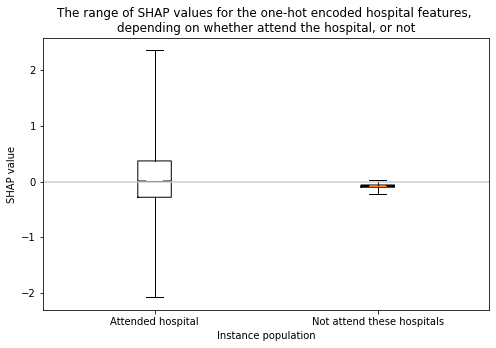

In [17]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.boxplot([shap_attended_hospital, shap_not_attend_these_hospitals],
            labels=["Attended hospital", "Not attend these hospitals"],
            whis=99999, notch=True);
title = ("The range of SHAP values for the one-hot encoded hospital features, "
         "\ndepending on whether attend the hospital, or not")

# Add line at Shap = 0
ax.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    
ax.set_title(title)
ax.set_xlabel("Instance population")
ax.set_ylabel("SHAP value");

#### Boxplot (individual hospitals)

Create a boxplot to show the range of SHAP values for each individual one-hot encoded hospital feature. 

Show the SHAP value as two populations: 1) the group of instances that attend the hospital [black], and 2) the group of instances that do not attend the hosptial [orange].

Order the hospitals in descending order of median SHAP value for the hospital the instance attended (so those that more often contribute to a yes-thrombolysis decision, through to those that most often contribute to a no-thrombolysis decision).

Firstly, to order the hospitals, create a dataframe containing the median SHAP value for each hosptial (for those instances that attended the hospital)

In [18]:
# Initialise lists
attend_stroketeam_min = []
attend_stroketeam_q1 = []
attend_stroketeam_median = []
attend_stroketeam_q3 = []
attend_stroketeam_max = []

# For each hospital, store descriptive statistics of SHAP values for those
#   instances that attend the hospital
for h in hospital_names:
    mask = df_hosp_shap_values['Stroke team'] == h
    data_stroke_team = df_hosp_shap_values[h][mask]
    q1, q3 = np.percentile(data_stroke_team, [25,75])
    attend_stroketeam_min.append(data_stroke_team.min())
    attend_stroketeam_q1.append(q1)
    attend_stroketeam_median.append(data_stroke_team.median())
    attend_stroketeam_q3.append(q3)
    attend_stroketeam_max.append(data_stroke_team.max())
    
# Create dataframe with 6 columns
df_hosp_shap_value_stats = pd.DataFrame(hospital_names, columns=["hospital"])
df_hosp_shap_value_stats["shap_min"] = attend_stroketeam_min
df_hosp_shap_value_stats["shap_q1"] = attend_stroketeam_q1
df_hosp_shap_value_stats["shap_median"] = attend_stroketeam_median
df_hosp_shap_value_stats["shap_q3"] = attend_stroketeam_q3
df_hosp_shap_value_stats["shap_max"] = attend_stroketeam_max

# sort in descending median SHAP value order
df_hosp_shap_value_stats.sort_values("shap_median", ascending=False, inplace=True)                
df_hosp_shap_value_stats.head(5)

,hospital,shap_min,shap_q1,shap_median,shap_q3,shap_max
25,GKONI0110I,0.175994,0.934903,1.147333,1.314293,2.120272
9,CNBGF2713O,0.185519,0.871191,1.145275,1.337732,2.030359
109,VKKDD9172T,0.100659,0.741192,0.982388,1.186568,2.090144
65,NTPQZ0829K,0.081631,0.679469,0.935364,1.119871,1.802614
32,HPWIF9956L,0.019245,0.602708,0.908798,1.288176,1.735104


Add admission figures to xlabel in boxplot

Create dataframe with admissions and thrombolysis rate per stroke team (index)

In [19]:
# Get Stroke team name, the stroke team admission numbers, and list of SHAP values for each instance that attended teh stroke team
unique_stroketeams_list = list(set(X_combined["Stroke team"]))
admissions = [X[f'team_{s}'].sum() for s in unique_stroketeams_list]

df_stroketeam_ivt_adms = pd.DataFrame(unique_stroketeams_list, 
                                      columns=["Stroke team"])
df_stroketeam_ivt_adms["Admissions"] = admissions
df_stroketeam_ivt_adms.set_index("Stroke team", inplace=True)
df_stroketeam_ivt_adms.sort_values("Admissions", ascending=True, inplace=True)

# Calculate IVT rate per hosptial
hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]

# Join IVT rate with admissions per hosptial
df_stroketeam_ivt_adms = df_stroketeam_ivt_adms.join(hosp_ivt_rate)

df_stroketeam_ivt_adms

,Admissions,Thrombolysis
Stroke team,,
JXJYG0100P,120,0.233333
VVDIY0129H,130,0.192308
YEXCH8391J,149,0.228188
CNBGF2713O,152,0.480263
XPABC1435F,166,0.216867
...,...,...
JINXD0311F,1377,0.368192
AKCGO9726K,1428,0.369748
OFKDF3720W,1488,0.228495


Create data for boxplot. Using order of hospitals from the hosp_shap_stats_df dataframe.

In [22]:
# Go through this order of hospitals
hospital_order = df_hosp_shap_value_stats["hospital"]
    
# Create list of SHAP main effect values (one per hospital) for instances that 
#   attend stroke team
attend_stroketeam_groups_ordered = []
not_attend_stroketeam_groups_ordered = []

# Create list of labels for boxplot "stroke team name (admissions)"
xlabel = []

# Through hospital in defined order (as determined above)
for h in hospital_order:
    # Attend
    mask = df_hosp_shap_values['Stroke team'] == h
    attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Not attend
    mask = df_hosp_shap_values['Stroke team'] != h
    not_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Label
    ivt_rate = int(df_stroketeam_ivt_adms['Thrombolysis'].loc[h] * 100)
    xlabel.append(f"{h} ({df_stroketeam_ivt_adms['Admissions'].loc[h]}, "
                  f"{ivt_rate}%)")

Plot the boxplot

Resource for using overall y min and max of both datasets on the 4 plots so have the same range
#https://blog.finxter.com/how-to-find-the-minimum-of-a-list-of-lists-in-python/#:~:text=With%20the%20key%20argument%20of,of%20the%20list%20of%20lists.

Shows the range of contributions to the prediction from this hospital when patients 1) do [black], and 2) do not [orange] attend this hosptial


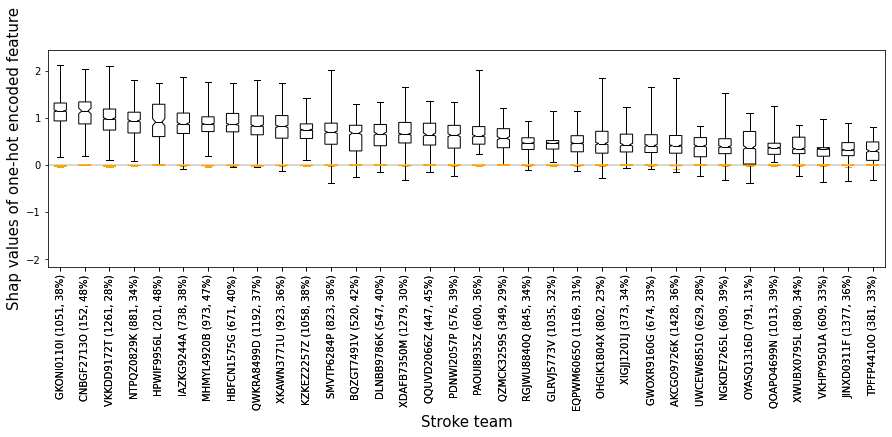

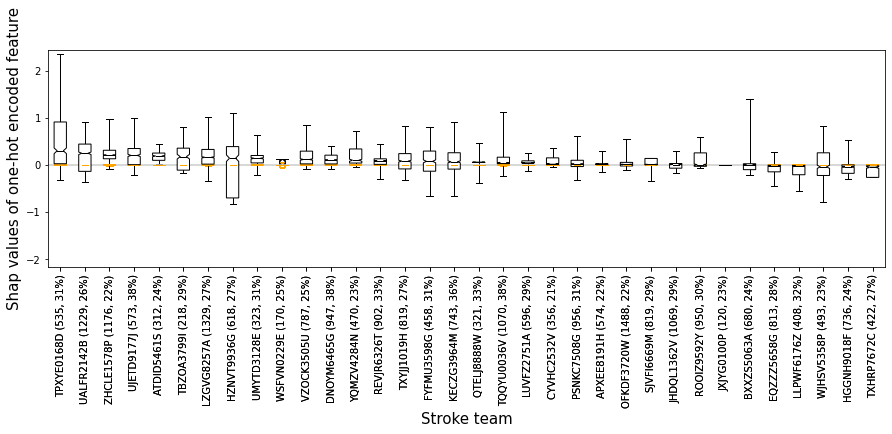

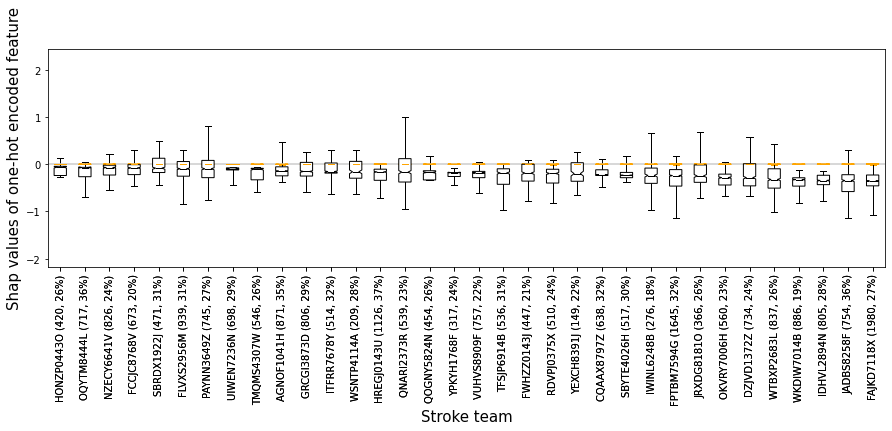

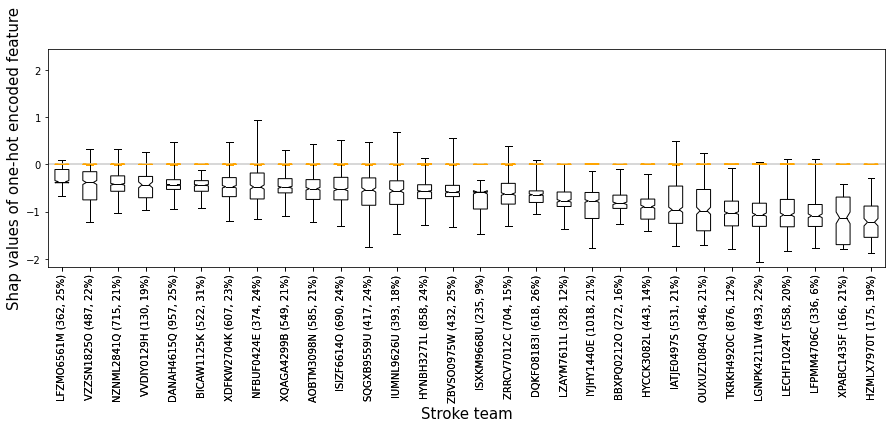

In [26]:
# Plot 34 hospitals on each figure to aid readability
print("Shows the range of contributions to the prediction from this hospital "
      "when patients 1) do [black], and 2) do not [orange] attend this "
      "hosptial")

# Group the hospitals into 35
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Use overall y min & max of both datasets on the 4 plots so have same range
ymin1 = min(min(attend_stroketeam_groups_ordered, key=min))
ymin2 = min(min(not_attend_stroketeam_groups_ordered, key=min))
ymax1 = max(max(attend_stroketeam_groups_ordered, key=max))
ymax2 = max(max(not_attend_stroketeam_groups_ordered, key=max))
ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

# Adjust min and max to accommodate some wriggle room
yrange = ymax - ymin1
ymin = ymin - yrange/50
ymax = ymax + yrange/50

# Create four plots
for i in range(4):

    # Create figure
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(1,1,1)
    # The contribution from this hospital when patients don't attend this 
    #    hosptial
    c1 = "orange"
    c2 = "orange"
    c3 = "white"
    ax.boxplot(not_attend_stroketeam_groups_ordered[st:ed],
               labels=xlabel[st:ed],#hospital_order[st:ed],
               whis=99999,patch_artist=True, notch=True,
               boxprops=dict(facecolor=c3, color=c1),
               capprops=dict(color=c1),
               whiskerprops=dict(color=c1),
               flierprops=dict(color=c1, markeredgecolor=c1),
               medianprops=dict(color=c2))
       
    # The contribution from this hospital when patients do attend this hosptial"
    c1 = "black"
    c2 = "black"
    c3 = "white"
    ax.boxplot(attend_stroketeam_groups_ordered[st:ed],
               labels=xlabel[st:ed],#df_hosp["hospital"][st:ed],
               whis=99999,patch_artist=True, notch=True,
               boxprops=dict(facecolor=c3, color=c1),
               capprops=dict(color=c1),
               whiskerprops=dict(color=c1),
               flierprops=dict(color=c1, markeredgecolor=c1),
               medianprops=dict(color=c2))

    plt.ylabel('Shap values of one-hot encoded feature',size=15)
    plt.xlabel('Stroke team (admissions, IVT rate)',size=15)
    plt.ylim(ymin, ymax)
    plt.xticks(rotation=90)
    # Add line at Shap = 0
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    plt.show()
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

Notice that when patients do not attend the hospital, the range of the SHAP values are largely centred on zero.
When patients do attend hosptial, the range of SHAP values are largely on one side of zero, or the other.

In [28]:
iqr_below_zero = df_hosp_shap_value_stats["shap_q3"] < 0
iqr_spans_zero = (df_hosp_shap_value_stats["shap_q1"] * 
                  df_hosp_shap_value_stats["shap_q3"])
iqr_above_zero = df_hosp_shap_value_stats["shap_q1"] > 0
iqr_is_zero1 = df_hosp_shap_value_stats["shap_q1"] == 0
iqr_is_zero2 = df_hosp_shap_value_stats["shap_q3"] == 0
iqr_is_zero = iqr_is_zero1 * iqr_is_zero2

print (f"There are {iqr_below_zero.sum()} hospitals whose interquartile range "
       f"is below zero")
print (f"There are {iqr_spans_zero.lt(0).sum()} hospitals whose interquartile "
       f"range spans zero")
print (f"There are {iqr_above_zero.sum()} hospitals whose interquartile range "
       f"is above zero")
print (f"There are {iqr_is_zero.sum()} hospitals whose interquartile range is "
       f"zero")

There are 59 hospitals whose interquartile range is below zero
There are 21 hospitals whose interquartile range spans zero
There are 51 hospitals whose interquartile range is above zero
There are 1 hospitals whose interquartile range is zero


How does the SHAP value for the one-hot encoded hospital features compare to the thrombolysis rate of the hospital?

Create dataframe containing the hospital's IVT rate and SHAP value (for those patients that attend the hospital).

In [32]:
hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]
df_hosp_plot = (
        df_hosp_shap_value_stats[["shap_median","hospital"]].copy(deep=True))
df_hosp_plot.set_index("hospital", inplace=True)
df_hosp_plot = df_hosp_plot.join(hosp_ivt_rate)
df_hosp_plot

,shap_median,Thrombolysis
hospital,,
GKONI0110I,1.147333,0.389153
CNBGF2713O,1.145275,0.480263
VKKDD9172T,0.982388,0.284695
NTPQZ0829K,0.935364,0.349603
HPWIF9956L,0.908798,0.487562
...,...,...
LGNPK4211W,-1.065176,0.227181
LECHF1024T,-1.069515,0.204301
LFPMM4706C,-1.089919,0.062500


Plot SHAP value for one-hot encoded hospital feature (median for those instances that attend the hospital) vs hospital IVT rate

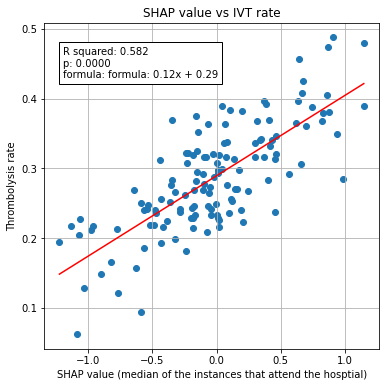

In [33]:
# Setup data for chart
x = df_hosp_plot['shap_median']
y = df_hosp_plot['Thrombolysis']

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(x, y)
ax.plot (x, y_pred, color = 'red')
f = 'formula: ' + str("{:.2f}".format(slope)) + 'x + ' + str("{:.2f}".format(intercept))
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}\nformula: {f}'
ax.text(-1.2, 0.43, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax.set_xlabel("SHAP value (median of the instances that attend the hosptial)")
ax.set_ylabel('Thrombolysis rate')
ax.set_title("SHAP value vs IVT rate")
plt.grid()

plt.show()

### Observations
* SHAP values for the one-hot encoded hospital features are very dependent on whether the instance attended the hospital or not
* SHAP values for the attended one-hot encoded hospital feature are largely one side of zero or the other. There are fewer instances in this population, but the range of SHAP values is wider.
* SHAP values for the not attended one-hot encoded hospitals are largely centred on zero. There are more instances in this population, but the range of SHAP values is narrower.
* 58% of the variability in hospital thrombolysis rate can be explained by the SHAP value for the one-hot encoded hospital feature (the median of those instances that attend the hospital).

### Extra code.

There was a journey to analyse the data and arrive at the boxplot (that we found to be the best visualisation yet to summarise this data). 

Below are the other ways we looked at the data as we arrived at the boxplot.

View descriptive stats

In [ ]:
df_hosp_shap_values.describe()

Are there any hospitals that only have one value for all instances?
This indicates that the feature was not used to divide a node in any of the trees.

In [ ]:
print("These hospitals have the same SHAP value for all patients")
for h in hospital_names:
    if df_hosp_shap_values[h].nunique() == 1:
        print(f"{h} has SHAP value {df_hosp_shap_values[h].unique()[0]} for all instances")

What's the range of number of unique values for each hospital for all patients?

In [ ]:
print ("The range of unique values for each hosptial")       
n_unique_per_hosptial = [df_hosp_shap_values[h].nunique() for h in hospital_names]                         
fig, axes = plt.subplots(1)
axes.hist(n_unique_per_hosptial);

Is there a relationship between number of unique shap values, and admission numbers?

In [ ]:
# Calculate the number of admissions per hospital
admissions = [X[h].sum() for h in hospital_names_ohe]

# Calculate number of unique SHAP values
n_unique_per_hosptial_all_instances = [df_hosp_shap_values[h].nunique() for h in hospital_names]

# Calculate number of unique SHAP values for patients that attend
n_unique_per_hosptial_attend = []
n_unique_per_hosptial_not_attend = []
for h in hospital_names:
    mask = df_hosp_shap_values["Stroke team"] == h
    n_unique_per_hosptial_attend.append(df_hosp_shap_values[h][mask].nunique())
    mask = np.logical_not(mask)
    n_unique_per_hosptial_not_attend.append(df_hosp_shap_values[h][mask].nunique())

# Store in dataframe
df_hospital_details = pd.DataFrame(admissions, columns=["admissions"])
df_hospital_details["number_of_unique_shap_values"] = n_unique_per_hosptial_all_instances
df_hospital_details["number_of_unique_shap_values_attend"] = n_unique_per_hosptial_attend
df_hospital_details["number_of_unique_shap_values_not_attend"] = n_unique_per_hosptial_not_attend

# Include hospital name (in both forms, original dataet, and ohe format)
#df_hospital_details["Stroke team ohe"] = hospital_names

#hospital_columns = [col[5:] for col in hospital_names]
df_hospital_details["Stroke team"] = hospital_names

In [ ]:
# Plot 1: Admissions vs number of unique SHAP values
#   With all instances contributing to SHAP value count
df_hospital_details.plot.scatter(x="admissions", 
                                 y="number_of_unique_shap_values")

# Plot 2: Admissions vs number of unique SHAP values
#   With only instances that attend hosptial contributing to SHAP value count
ax = df_hospital_details.plot.scatter(x="admissions", 
                                      y="number_of_unique_shap_values_attend")
# Include x = y line (shows the max number of of unique values)
max_axis_value = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([0, max_axis_value], [0, max_axis_value], c='0.5')

# Plot 3: Admissions vs number of unique SHAP values
#   With only instances that do not attend hosptial contributing to SHAP value count
df_hospital_details.plot.scatter(x="admissions",
                                 y="number_of_unique_shap_values_not_attend")

Let's look at a hospital with the most unique values

In [ ]:
row_index = df_hospital_details["number_of_unique_shap_values"].idxmax()
stroke_team_max_n_unique = df_hospital_details["Stroke team"].iloc[row_index]
print(f"Hospital {stroke_team_max_n_unique} has "
      f"{df_hospital_details['number_of_unique_shap_values'].max()} "
      f"unique values")

Look at descriptive stats for this hospital

In [ ]:
df_hosp_shap_values[stroke_team_max_n_unique].describe()

What's the difference between the SHAP value for this hospital for the instances that attended it, compared to those instances that didn't?

Colour histogram bars to represent: Green for positive SHAP value, Grey for 0, and Red for negative SHAP value.

In [ ]:
def create_histogram_with_colours(data, bins, ax):

    """
    data:
    bins:
    ax:
    
    Return ax
    """
    
    N, bins, patches = ax.hist(data,
                               edgecolor='white', linewidth=0.2, bins=bins);

    for i in range(N.shape[0]):
        if bins[i] < 0 and bins[i+1] < 0:
                patches[i].set_facecolor('red')
        elif bins[i] > 0 and bins[i+1] > 0:
                patches[i].set_facecolor('green')
        else:
            patches[i].set_facecolor('black')

    return(ax)

In [ ]:
stroke_team = stroke_team_max_n_unique

mask1 = df_hosp_shap_values["Stroke team"] == stroke_team
shap_values_attend = df_hosp_shap_values[stroke_team][mask1]

mask2 = np.logical_not(mask1)
shap_values_not_attend = df_hosp_shap_values[stroke_team][mask2]

# Plot histogram of SHAP values for all instances
fig, ax = plt.subplots()
create_histogram_with_colours(df_hosp_shap_values[stroke_team], 100, ax)
ax.set_xlabel(f"SHAP")
ax.set_ylabel("Number of instances")
print(f"{stroke_team}. Number of unique values for all patients (attended or "
      "not): {df_hosp_shap_values[stroke_team].nunique()}")
print(f"Number of patients {df_hosp_shap_values[stroke_team].shape[0]}")
plt.show

# Plot histogram of SHAP values for instances attend hospital
mask1 = mask1 * 1
s1 = mask1.sum()
fig, ax = plt.subplots()
ax = create_histogram_with_colours(shap_values_attend, 100, ax)
ax.set_xlabel(f"SHAP")
ax.set_ylabel("Number of instances")
print(f"{stroke_team}. Number of unique values for those patients who "
      "attended: {shap_values_attend.nunique()}")
print(f"Number of patients {s1}")
plt.show

# Plot histogram of SHAP values for instances not attend hospital
mask2 = mask2 * 1
s2 = mask2.sum()
fig, ax = plt.subplots()
ax = create_histogram_with_colours(shap_values_not_attend, 100, ax)
ax.set_xlabel(f"SHAP")
ax.set_ylabel("Number of instances")
print(f"{stroke_team}. Number of unique values for those patients who do not "
      "attended: {shap_values_not_attend.nunique()}")
print(f"Number of patients {s2}")
plt.show


So there's two populations, but in the top plot you can not see the histogram for the instances that attended the hospital, as their frequency is too few and the plot is dominated by the frequency range for the number of patients who did not attend the hosptial.

Those that attend have a higher SHAP value, but there's fewer instances so can not see these values.
Those that do not attend have a low SHAP value, a smaller range of values, but far more instances, so dominates the y axis, but can not see the spread (as the other population has determines the x axis range).

Better to view as two populations.

Plot a boxplot for the SHAP values of each hospital (for all instances)

In [ ]:
# Create list of values for each boxplot (one per hospital)
stroketeam_groups = []
for h in hospital_names:
    stroketeam_groups.append(df_hosp_shap_values[h])

In [ ]:
# Create a figure with 35 hospitals in each to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "for all the instances")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Plot properties
c1 = "navy"
c2 = "navy"
c3 = "white"

# Create four plots
for i in range(4):
    #plot boxplot
    plt.figure(figsize=(15, 4))
    plt.boxplot(stroketeam_groups[st:ed],
                labels=df_hosp_shap_values.columns[st:ed],
                whis=9999999, patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))
    plt.ylabel('Shap values of one-hot encoded feature',size=15)
    plt.xlabel('Stroke team',size=15)
    plt.xticks(rotation=90)
    plt.show()
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

Shows that hospitals have the majority of their cases at value 0, and some have a longer range than others, with most having their range entirely on one side of 0 or the other.

Let's plot it again, twice, showing only those instances that go to the hospital, and again when they do not.

Include instances that attend the hospital only

In [ ]:
# Create list of values for each boxplot (one per hospital), only include SHAP 
#   value for instances that attend stroke team
attend_stroketeam_groups = []
for h in hospital_names:#df_hosp_shap_values.columns[:-1]:
    mask = df_hosp_shap_values['Stroke team'] == h#col[5:] #drop "team_"
    attend_stroketeam_groups.append(df_hosp_shap_values[h][mask])

In [ ]:
# Create a figure with 35 hospitals in each to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "when patients attend this hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Plot properties
c1 = "black"
c2 = "black"
c3 = "white"

# Create four plots
for i in range(4):
    plt.figure(figsize=(15, 4))
        
    plt.boxplot(attend_stroketeam_groups[st:ed],
                labels=df_hosp_shap_values.columns[st:ed],
                whis=999999,patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))

    plt.ylabel('Shap values of one-hot encoded feature',size=15)
    plt.xlabel('Stroke team',size=15)
    plt.xticks(rotation=90)
    plt.show()
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

Edit data so only contains instances when not go to hospital

In [ ]:
# Only include SHAP value for instances that do not attend stroke team
not_attend_stroketeam_groups = []
for h in hospital_names:#df_hosp_shap_values.columns[:-1]:
    mask = df_hosp_shap_values['Stroke team'] != h#col[5:] #drop "team_"
    not_attend_stroketeam_groups.append(df_hosp_shap_values[h][mask])

In [ ]:
# Create a figure with 35 hospitals in each to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "when patients do not attend this hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Plot properties
c1 = "orange"
c2 = "orange"
c3 = "white"
 
# Create four plots
for i in range(4):
    plt.figure(figsize=(15, 4))

    plt.boxplot(not_attend_stroketeam_groups[st:ed],
                labels=df_hosp_shap_values.columns[st:ed],
                whis=999999,patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))
        
    plt.ylabel('Shap values of one-hot encoded feature',size=15)
    plt.xlabel('Stroke team',size=15)
    plt.xticks(rotation=90)
    plt.show()
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

In [ ]:
# Two box plots on 1 plot (spread of SHAP when instance attend, and not attend, hospital)

# Create a figure with 35 hospitals in each to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "when patients 1) do [black], and 2) do not [orange] attend this hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Create four plots
for i in range(4):
    #plot boxplot
    plt.figure(figsize=(15, 4))

    # The contribution from this hospital when patients do not attend this hosptial
    c1 = "orange"
    c2 = "orange"
    c3 = "white"
    plt.boxplot(not_attend_stroketeam_groups[st:ed],
                labels=df_hosp_shap_values.columns[st:ed],
                whis=99999,patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))
        
    # The contribution from this hospital when patients do attend this hosptial
    c1 = "black"
    c2 = "black"
    c3 = "white"
    plt.boxplot(attend_stroketeam_groups[st:ed],
                labels=df_hosp_shap_values.columns[st:ed],
                whis=99999,patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))

    plt.ylabel('Shap values of one-hot encoded feature',size=15)
    plt.xlabel('Stroke team',size=15)
    plt.xticks(rotation=90)
    plt.show()
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

In [ ]:
# Create list of values for each boxplot (one per hospital)
#   only include SHAP value for instances that attend stroke team
attend_stroketeam_groups = []
for h in hospital_names:#df_hosp_shap_values.columns[:n_hospitals]:
    mask = df_hosp_shap_values['Stroke team'] == h#col[5:] #drop "team_"
    attend_stroketeam_groups.append(df_hosp_shap_values[h][mask])
    
# Only include SHAP value for instances that do not attend stroke team
not_attend_stroketeam_groups = []
for h in hospital_names:#df_hosp_shap_values.columns[:n_hospitals]:
    mask = df_hosp_shap_values['Stroke team'] != h#col[5:] #drop "team_"
    not_attend_stroketeam_groups.append(df_hosp_shap_values[h][mask])
    

# Plot 35 hospitals on each figure to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "when patients 1) do [black], and 2) do not [orange] attend this hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Create four plots
for i in range(4):
    #plot boxplot
    plt.figure(figsize=(15, 4))

    # The contribution from this hospital when patients do not attend this hosptial
    c1 = "orange"
    c2 = "orange"
    c3 = "white"
    plt.boxplot(not_attend_stroketeam_groups[st:ed],
                labels=df_hosp_shap_values.columns[st:ed],
                whis=99999,patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))
        
    # The contribution from this hospital when patients do attend this hosptial
    c1 = "black"
    c2 = "black"
    c3 = "white"
    plt.boxplot(attend_stroketeam_groups[st:ed],
                labels=df_hosp_shap_values.columns[st:ed],
                whis=99999,patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))

    plt.ylabel('Shap values of one-hot encoded feature',size=15)
    plt.xlabel('Stroke team',size=15)
    plt.xticks(rotation=90)
    plt.show()
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

Does it help understanding to represent this as histograms?

Create three matrix of histograms. 

* One with all the instances to each hosptial
* One with just the instances that attend each hosptial
* One with just the instances that don't attend each hosptial.

One with all the instances to each hosptial (forcing same axis ranges)

In [ ]:
# Find the largest value used for the y axis in all of the histograms in the 
#   subplots (use this to set the max for each subplot)
y_max = -1
x_min = 99
x_max = -99
fig, axes = plt.subplots(1)
for h in hospital_names:
    # Plot histogram
    axes.hist(df_hosp_shap_values[h])
    # Get axis limits
    ylims = axes.get_ylim()
    # Store if greater than found so far
    y_max = max(y_max, ylims[1])
    # Get axis limits
    xlims = axes.get_xlim()
    # Store if greater than found so far
    x_min = min(x_min, xlims[0])
    x_max = max(x_max, xlims[1])
# Don't display plot
plt.close(fig)

# Define width of histogram bins based on the x axis range
bin_width = (abs(math.floor(xlims[0])) + abs(math.ceil(xlims[1])))/20

# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for h in hospital_names:
    n_unique = df_hosp_shap_values[h].nunique()
    ax=axes[count]
    create_histogram_with_colours(df_hosp_shap_values[h],
            np.arange(math.floor(xlims[0]),math.ceil(xlims[1]),bin_width),
            ax)
    ax.set_xlabel(f"SHAP value for {h} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances")
    ax.set_ylim(0, (y_max*1.1))
    count += 1

# Define figure display
fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()

One with just the instances that attend each hosptial

In [ ]:
# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for h in hospital_names:
    mask = X_combined["Stroke team"] == h #drop "team_"
    shap_values_not_attend = df_hosp_shap_values[h][mask]
    n_unique = shap_values_not_attend.nunique()
    ax=axes[count]
    create_histogram_with_colours(shap_values_not_attend, 20, ax)
#    ax.hist(shap_values_not_attend, bins=20)
    ax.set_xlabel(f"SHAP value for {h} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances \n(not attend hosptial)")
#    ax.set_ylim(0, y_max)
#    ax.set_xlim(x_min, x_max)
    count += 1

fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()

One with just the instances that don't attend each hosptial.

In [ ]:
# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for h in hospital_names:
    mask = X_combined["Stroke team"] == h #drop "team_"
    mask = np.logical_not(mask)# Those that didn't attend
    shap_values_not_attend = df_hosp_shap_values[h][mask]
    n_unique = shap_values_not_attend.nunique()
    ax=axes[count]
    create_histogram_with_colours(shap_values_not_attend, 20, ax)
#    ax.hist(shap_values_not_attend, bins=20)
    ax.set_xlabel(f"SHAP value for {h} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances \n(not attend hosptial)")
#    ax.set_ylim(0, y_max)
#    ax.set_xlim(x_min, x_max)
    count += 1

fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()

Code showing the same histograms, with each having the same x axis range and y axis range

In [ ]:
# Find the largest value used for the y axis in all of the histograms in the 
#   subplots (use this to set the max for each subplot)
y_max = -1
x_min = 99
x_max = -99
fig, axes = plt.subplots(1)
for h in hospital_names:
    # mask data for those that attend hospital
    mask = df_hosp_shap_values["Stroke team"] == h
    # Those that didn't attend
    mask = np.logical_not(mask)
    shap_values_attend = df_hosp_shap_values[h][mask]
    n_unique = shap_values_attend.nunique()
    # Plot histogram
    axes.hist(shap_values_attend)
    # Get axis limits
    ylims = axes.get_ylim()
    # Store if greater than found so far
    y_max = max(y_max, ylims[1])
    # Get axis limits
    xlims = axes.get_xlim()
    # Store if greater than found so far
    x_min = min(x_min, xlims[0])
    x_max = max(x_max, xlims[1])
# Don't display plot
plt.close(fig)

# Define width of histogram bins based on the x axis range
bin_width = (abs(math.floor(xlims[0])) + abs(math.ceil(xlims[1])))/20

# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for h in hospital_names:
    # mask data for those that attend hospital
    mask = df_hosp_shap_values["Stroke team"] == h
    # Those that didn't attend
    mask = np.logical_not(mask)
    shap_values_attend = df_hosp_shap_values[h][mask]
    n_unique = shap_values_attend.nunique()
    # Plot histogram
    ax=axes[count]
    ax.hist(shap_values_attend, 
            bins=np.arange(math.floor(xlims[0]),math.ceil(xlims[1]),bin_width))
    ax.set_xlabel(f"SHAP value for {h} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances")
    ax.set_ylim(0, (y_max*1.1))
    count += 1

# Define figure display
fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()